# 1.1 Value object of micro-grad and its visualization

In [1]:
class Value:
    def __init__(self, data , _children=() , _op = ''  ,label = ''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return "Value(data = %.4f, op = %s)" % (self.data, self._op)
    
    def __add__(self , other):
        out = Value(self.data + other.data , (self , other), "+")
        return out
    def __mul__(self , other):
        out = Value(self.data * other.data, (self, other), "*")
        return out

In [2]:
# leaf nodes
a = Value(2.0 , label   = 'a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'

# forward pass
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

In [3]:
d._prev, d._op

({Value(data = -6.0000, op = *), Value(data = 10.0000, op = )}, '+')

### Ploting the graph

In [4]:
%pip install graphviz


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        name = getattr(n, 'label', '')
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')

        if n._op:
            # for any value in the graph, create a rectangular('record') op node for it
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to n1._op to n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [6]:
L.grad = 1.0
d.grad = f.data
f.grad = d.data
c.grad = d.grad
e.grad = d.grad
a.grad = e.grad * b.data
b.grad = e.grad * a.data

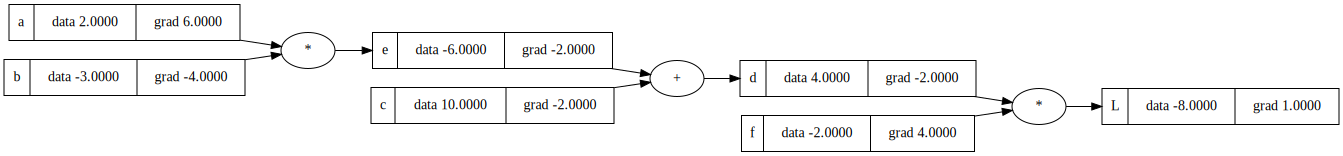

In [7]:
draw_dot(L)

## Understanding manual backpropgation





Backpropgation is a method to figure out how to adjust all the parts of a model . Where we start with the final value and work backward , using chain rule of calculus, you will calculate how each part of the model contribute to the final result


## Manual Backpropgation 

1. Start with the final value L 
 ```math
dl/dx = (f(x+h) - f(x)) / h
= (f.x +f.h - f.x) / h
= f.h/h
= f
```
hence :
```arm
    L.grad = 1.0
```

2. Working backwards 

```math
L = d * f
```

```math
f = dl/dd
```

- defination of the derivative
```math
(f(x+h) - f(x))/h
```

```math
    (f(d + h) - f(d) )/h = (f.d + f.h -f.d)/h = f.h/h = f
```

hence : 
```arm
    f.grad = d.data
    d.grad = f.data
```

3. working backwards : 
    
    Here local derivative of dd/dc , dd/de will always be 1.0

    to find out the derivative of dl/dc , dl/de we have apply the chain rule 

    Chain rule :The chain rule states that the instantaneous rate of change of z relative to y and that of of y relative to x allows one to calculate the instantaneous rate of change  of z relative to x as the product of the two rates of change.

    ```math
        dz/dx = dz/dy.dy/dx
    ```

    To figure out the value of :

    ```math
        dc/dl , de/dl
    ```

    according to chain rule :

    ```math
        dc/dl = dc/dd .dd/dl
    ```
    ```math
        de/dl = de/dd . dd/dl
    ```

    Hence de/dd , dc/dd = 1 and dd/dl = -2

    value of `c.grad = d.grad `
     and
            `e.grad = d.grad`


4. Final node : 

    we have to find 

     ```math
        da/dl , db/dl
     ```

    Chain rule 
   
     ```math
        da/dl = db/de . de/dl
     ```

    hence the Value of de/dl = d.grad 

    ```math
        db/de  , e = a * b
    ```

    ```math
    db /de = -3
    ```
     so ,
    ```math
     da/de = 2
    ```
    which is 
```math
    db/de = a.data * d.grad = -4
```
```math
    da/de = b.data * d.grad = 6
```



